In [12]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (14, 8)
import matplotlib.pyplot as p
import seaborn as sns
sns.set(font_scale=1.7)

In [2]:
from ring import RingNetwork

In [6]:
model_parameters = {
    'simulation_time': 10.0,    # total simulation time, sec
    'U': 0.3,           # baseline neurotransmitter release probability, a.u.
    'D': 0.5,           # internal noise intensity
    'inhibitory_weight': -12,          # E->I synaptic weight
    'excitatory_weight': 30,           # E->E recurrent synaptic weight
    'T': 0.2,           # duration of incoming stimuli, sec
    'C': 5.0,           # amplitude of incoming stimuli, a.u.
    'freq': 4,          # stimulus Poisson rate, Hz
    'tau_r': 0.01,      # readout time constant, sec
    'tau': 0.01,        # firing rate decay time constant, sec
    'tau_n': 0.1,       # noise correlation time constant, sec
    'tau_rec': 0.8,     # time constant for recovery of synaptic resourses, sec
    'N': 100,           # number of neural populations in the network
}

In [7]:
release_probability = 0.2
baseline_current = -1

ring = RingNetwork(U=release_probability,
                   model_parameters=model_parameters)

ring.I0 = baseline_current

In [8]:
ring.integrate(simulation_time=5.0)

100%|██████████| 2499/2499 [00:03<00:00, 783.83it/s]


In [10]:
readout_error, exact_readout_error = ring.calculate_readout_error()

In [11]:
# error for the optimal lag value and *some* number of readout subpopulations

detection_error = np.amin(np.mean(readout_error, axis=2)[:, 3])

In [12]:
detection_error

0.36451994554041317

### Let's try to reproduce the benchmark result that there is an optimal value of release probability $U$ for which detection error is minimal. 

Even short simulations for 100 sec are enough to reproduce the detection error trend

In [20]:
%time 

from multiprocessing import Process

simulation_time = 100.0
prob_range = np.arange(0.05, 0.5, 0.05)
detection_errors = []

def calculate_error(release_probability):
    
    ring = RingNetwork(U=release_probability,
                       model_parameters=model_parameters)

    ring.integrate(simulation_time=simulation_time, 
                   show_iterations=True)
    
    readout_error, exact_readout_error = ring.calculate_readout_error()
    
    return readout_error

errors = []

for release_probability in prob_range:
    error = calculate_error(release_probability=release_probability)
    errors.append(error)

  0%|          | 67/49999 [00:00<01:14, 666.48it/s]

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 9.54 µs


100%|██████████| 49999/49999 [01:30<00:00, 553.38it/s]


In [40]:
curve = {}

for readouts in range(errors[0].shape[1]):
    curve[readouts] = []
    for index in range(len(errors)):
        curve[readouts].append(360 / (4 * np.pi) * np.amin(np.mean(errors[index], axis=2), axis=0)[readouts])

Text(0.5,1,'Detection error value vs. release probability in a ring network')

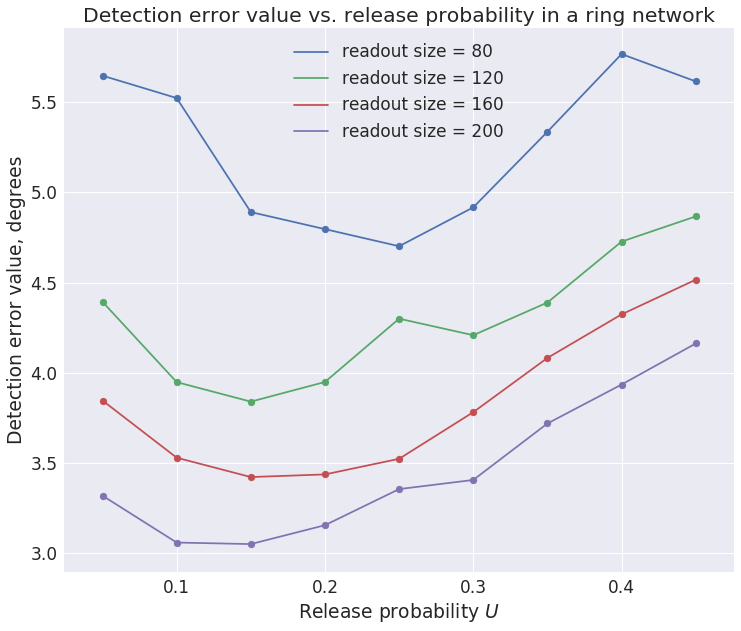

In [49]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 12, 10

readout_sizes = np.linspace(int(model_parameters['N'] / 10), 
                            model_parameters['N'], 10, dtype='int')

legend_labels = []

for readouts in range(2, errors[0].shape[1]):
    if (readouts % 2):
        p.scatter(prob_range, curve[readouts])
        p.plot(prob_range, curve[readouts])
        legend_labels.append('readout size = %i' % readout_sizes[readouts])
        
p.legend(legend_labels)
p.xlabel('Release probability $U$')
p.ylabel('Detection error value, degrees')
p.title('Detection error value vs. release probability in a ring network')

Let's pose this as an optimization problem, where our cost function is the average detection error value. Each evaluation of the error value takes some time and is noisy for short simulation time spans (e.g. ~100 sec), therefore we use a method robust to this. Here we try with differential evolution:

In [5]:
def error_function(parameters):
    
    simulation_time = 100.0
    
    U = parameters 
    
    ring = RingNetwork(U=U,
                       model_parameters=model_parameters)
    
    print('Evaluating detection error at U=%f...' % U)
    
    ring.integrate(simulation_time=simulation_time, 
                   show_iterations=False)
    
    readout_error, exact_readout_error = ring.calculate_readout_error()
    
    detection_error = np.amin(np.mean(readout_error, axis=2), axis=0)[-1]
    
    return detection_error

In [7]:
from hyperopt import hp
from hyperopt import fmin, tpe

In [12]:
params = hp.uniform('U', 0.01, 0.98)

In [13]:
best = fmin(error_function,
            params,
            algo=tpe.suggest,
            max_evals=10)

Evaluating detection error at U=0.611681...
Evaluating detection error at U=0.750577...
Evaluating detection error at U=0.552344...
Evaluating detection error at U=0.142389...
Evaluating detection error at U=0.686873...
Evaluating detection error at U=0.413548...
Evaluating detection error at U=0.736960...
Evaluating detection error at U=0.920604...
Evaluating detection error at U=0.348271...
Evaluating detection error at U=0.885600...


Let's calculate readout error values for variations of model's parameters.
In general for a fixed value of $U$ and a set of model parameters (E->E weight, E->I weight, etc.) we want to choose a specific value for $I_{baseline}$ so that the mean firing rate $\approx$ the target firing rate for each combination of parameters


For now let's just look at combitations of parameters and ($U$, $I_{baseline}$) taken from the original calculated curve. Average firing rates of corresponding networks would be different  

First, let's see how error depends on $U$ for fixed values of $I_{baseline}$ (firing rate changes accordingly):

In [2]:
!head -n 3 results_UI0.dat
# first_parameter, second_parameter, U, set of errors for different N_readout

0.050000, -3.000000, 0.050000, 0.406501, 0.273413, 0.235934, 0.200907, 0.173593, 0.162344, 0.148198, 0.135071, 0.125222, 0.118557
0.050000, -2.777778, 0.050000, 0.409643, 0.273452, 0.235326, 0.201748, 0.174665, 0.162464, 0.148701, 0.134110, 0.124918, 0.118504
0.050000, -2.555556, 0.050000, 0.413763, 0.272877, 0.233078, 0.199490, 0.174390, 0.162805, 0.147987, 0.133201, 0.124817, 0.117478


In [87]:
data = np.loadtxt('./data/results_UI0.dat',
                  delimiter=',')
df = pd.DataFrame(data)

In [5]:
df.head()

0         1     2         3         4         5         6         7   \
0  0.05 -3.000000  0.05  0.406501  0.273413  0.235934  0.200907  0.173593   
1  0.05 -2.777778  0.05  0.409643  0.273452  0.235326  0.201748  0.174665   
2  0.05 -2.555556  0.05  0.413763  0.272877  0.233078  0.199490  0.174390   
3  0.05 -2.333333  0.05  0.411387  0.272200  0.234342  0.201563  0.174747   
4  0.05 -2.111111  0.05  0.409180  0.272507  0.234680  0.200737  0.173545   

         8         9         10        11        12  
0  0.162344  0.148198  0.135071  0.125222  0.118557  
1  0.162464  0.148701  0.134110  0.124918  0.118504  
2  0.162805  0.147987  0.133201  0.124817  0.117478  
3  0.163301  0.147396  0.134012  0.124138  0.117256  
4  0.162291  0.146668  0.132058  0.124454  0.116382

In [8]:
# we calculated error vs. U for the following fixed I_baseline values:
np.sort(df[1].value_counts().index.values)

array([-3.      , -2.777778, -2.555556, -2.333333, -2.111111, -1.888889,
       -1.666667, -1.444444, -1.222222, -1.      ])

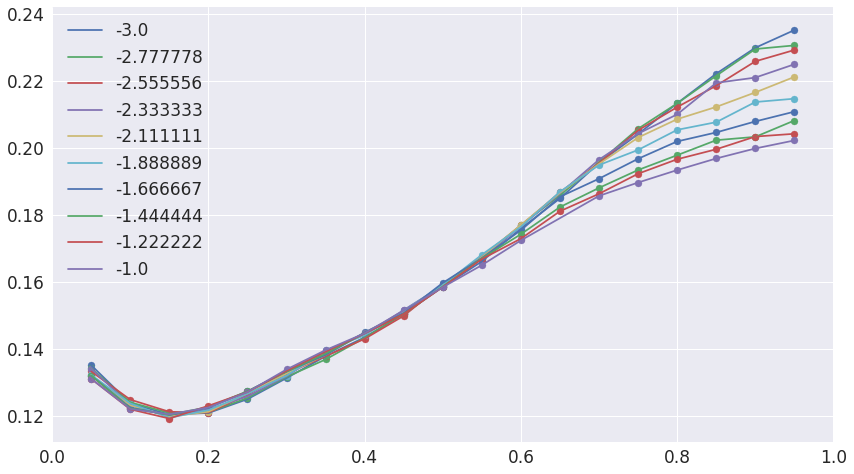

In [13]:
second_param_values = np.sort(df[1].value_counts().index.values)

readout_index = 10

for second_param in second_param_values:

    first_param = df[df[1] == second_param][0].values
    error = df[df[1] == second_param][readout_index].values
    p.plot(first_param, error)
    p.scatter(first_param, error)
        
p.legend(second_param_values)

In [56]:
def plot_error_vs_params(df, first_param_label, 
                         second_param_label, readout_index=10):
    
    second_param_values = np.sort(df[1].value_counts().index.values)

    for second_param in second_param_values:

        first_param = df[df[1] == second_param][0].values
        error = df[df[1] == second_param][readout_index].values
        p.plot(first_param, error)
        p.scatter(first_param, error)
        
    p.legend(second_param_values, 
             bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    p.xlabel(first_param_label)
    p.ylabel('Detection error')
    p.show()
    
    first_param_values = np.sort(df[0].value_counts().index.values)[::2]
    
    for first_param in first_param_values:

        second_param = df[df[0] == first_param][1].values
        error = df[df[0] == first_param][readout_index].values
        p.plot(second_param, error)
        p.scatter(second_param, error)
        
    p.legend(first_param_values, 
             bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    p.xlabel(second_param_label)
    p.ylabel('Detection error')
    p.show()
    
    i_index = dict([(value, index) for index, value in \
          enumerate(np.sort(df[0].value_counts().index.values))])
    j_index = dict([(value, index) for index, value in \
          enumerate(np.sort(df[1].value_counts().index.values))])
    
    data = np.zeros((len(i_index), len(j_index)))

    for index, item in enumerate(df[readout_index]):
        ii_index = i_index[df[0].iloc[index]]
        jj_index = j_index[df[1].iloc[index]]
        data[ii_index][jj_index] = item
        
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if data[i][j] == 0:
                if data[i-1][j] != 0:
                    data[i][j] = data[i-1][j]
                elif data[i+1][j] != 0:
                    data[i][j] = data[i+1][j]
                    
    sns.heatmap(data.transpose(),
            xticklabels=list(i_index.keys()),
            yticklabels=list(j_index.keys()),
            cmap='pink')
    p.xlabel(first_param_label)
    p.ylabel(second_param_label)

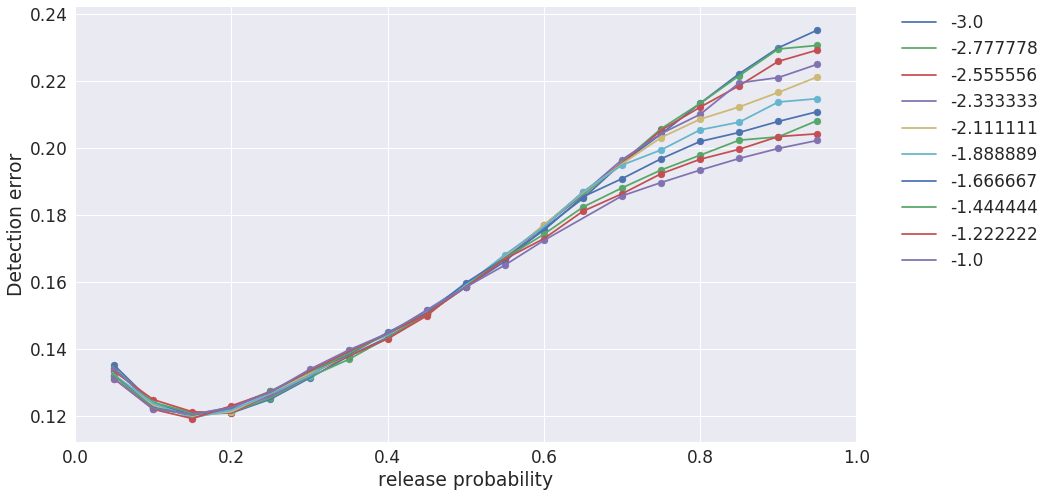

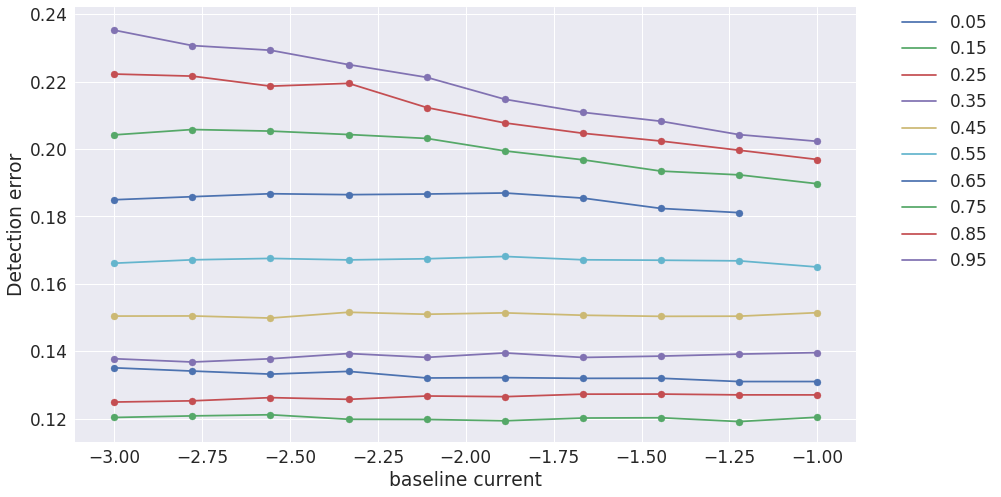

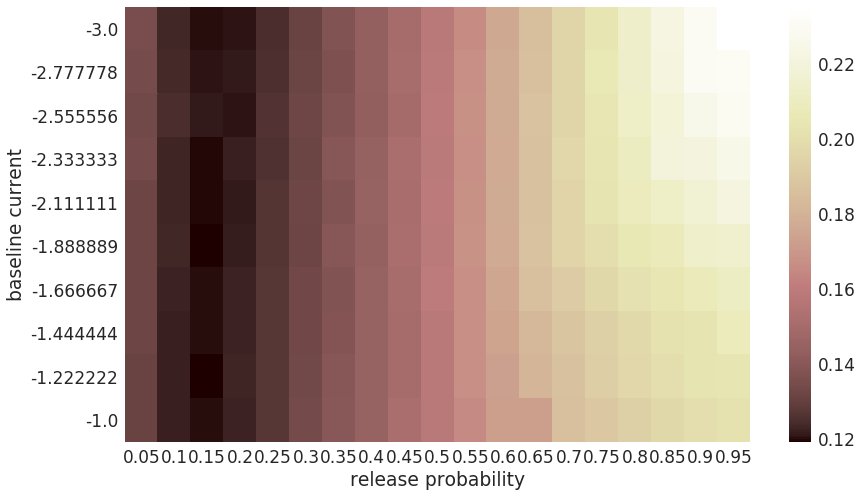

In [58]:
plot_error_vs_params(df, 
                     'release probability', 'baseline current')

Error vs. $U$ does not significantly change for different fixed levels of $I_{baseline}$.
Errors at large $U$ decrease slightly with increasing $I_{baseline}$, and stay ~constant at low $U$ 

In [88]:
data = np.loadtxt('./data/results_excweight.dat',
                  delimiter=',')
df = pd.DataFrame(data)
df.head()

0     1     2         3         4         5         6         7   \
0  0.05   5.0  0.05  0.446974  0.302578  0.257035  0.222300  0.193304   
1  0.05  10.0  0.05  0.443828  0.295323  0.250804  0.217568  0.188414   
2  0.05  12.5  0.05  0.438094  0.292800  0.251681  0.215851  0.186428   
3  0.05  15.0  0.05  0.440186  0.292167  0.247161  0.213162  0.183939   
4  0.05  17.5  0.05  0.433444  0.288187  0.244250  0.209427  0.182269   

         8         9         10        11        12  
0  0.180098  0.163177  0.147366  0.138550  0.131899  
1  0.176947  0.159417  0.144817  0.135564  0.128664  
2  0.174036  0.158536  0.143649  0.133071  0.126110  
3  0.172069  0.156033  0.142409  0.131746  0.125253  
4  0.170167  0.154835  0.140377  0.131528  0.123498

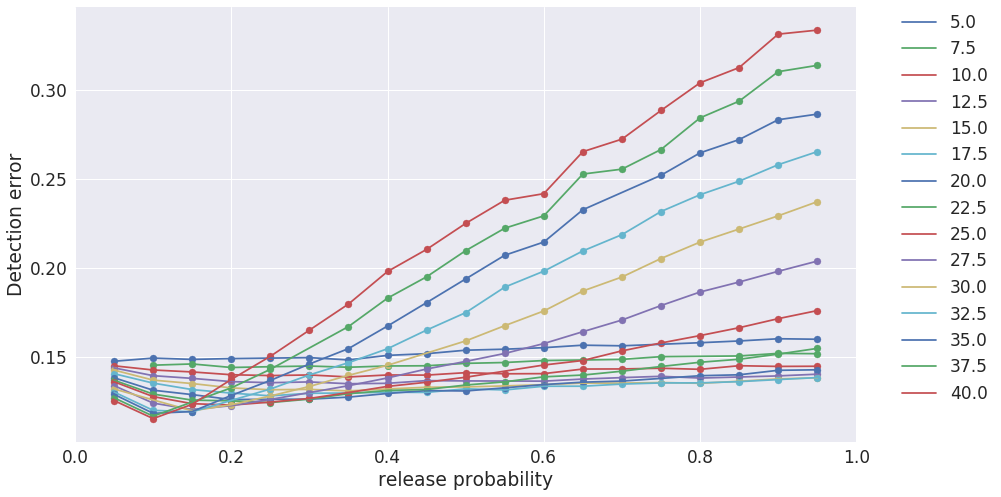

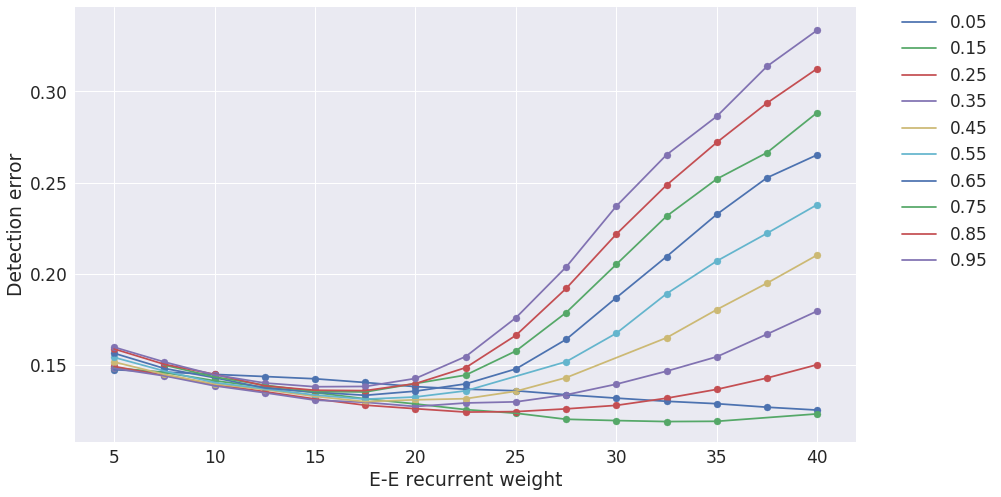

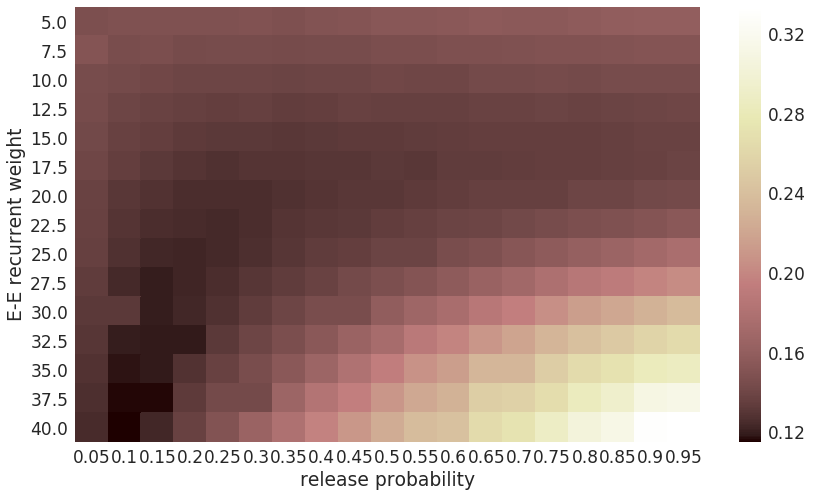

In [80]:
plot_error_vs_params(df, 
                     'release probability', 'E-E recurrent weight')

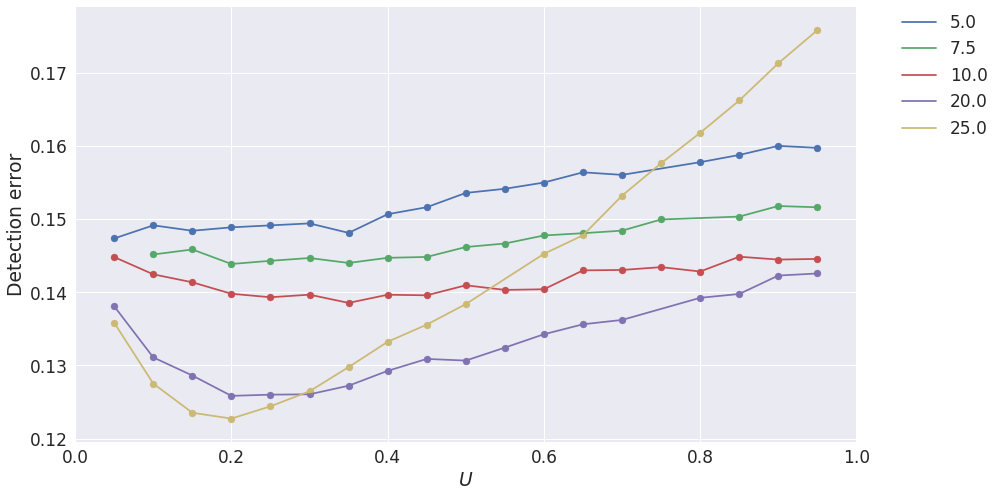

In [86]:
second_param_values = [5., 7.5, 10., 20., 25.]

for second_param in second_param_values:

    first_param = df[df[1] == second_param][0].values
    error = df[df[1] == second_param][readout_index].values
    p.plot(first_param, error)
    p.scatter(first_param, error)
        
    p.legend(second_param_values, 
             bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    p.xlabel('$U$')
    p.ylabel('Detection error')


For ~$U > 0.3$ there is an optimal value of E-E weight minimizing the error.
For E-E weight > ~20 the error vs. $U$ curve has a clear optimum

In [89]:
data = np.loadtxt('./data/results_inhweight.dat',
                  delimiter=',')
df = pd.DataFrame(data)
df.head()

0         1     2         3         4         5         6         7   \
0  0.05 -1.000000  0.05  0.421859  0.265585  0.221809  0.193997  0.166647   
1  0.05 -2.714286  0.05  0.421317  0.266843  0.222151  0.194979  0.166861   
2  0.05 -4.428571  0.05  0.418141  0.266229  0.226092  0.196145  0.167460   
3  0.05 -6.142857  0.05  0.418749  0.267479  0.226301  0.197253  0.169032   
4  0.05 -7.857143  0.05  0.419974  0.269597  0.226961  0.196685  0.170075   

         8         9         10        11        12  
0  0.157415  0.140839  0.127440  0.118078  0.111397  
1  0.158333  0.142364  0.127284  0.119157  0.112318  
2  0.157845  0.142300  0.128692  0.119689  0.113506  
3  0.158082  0.143714  0.129300  0.120994  0.113500  
4  0.158487  0.143734  0.129811  0.121483  0.114401

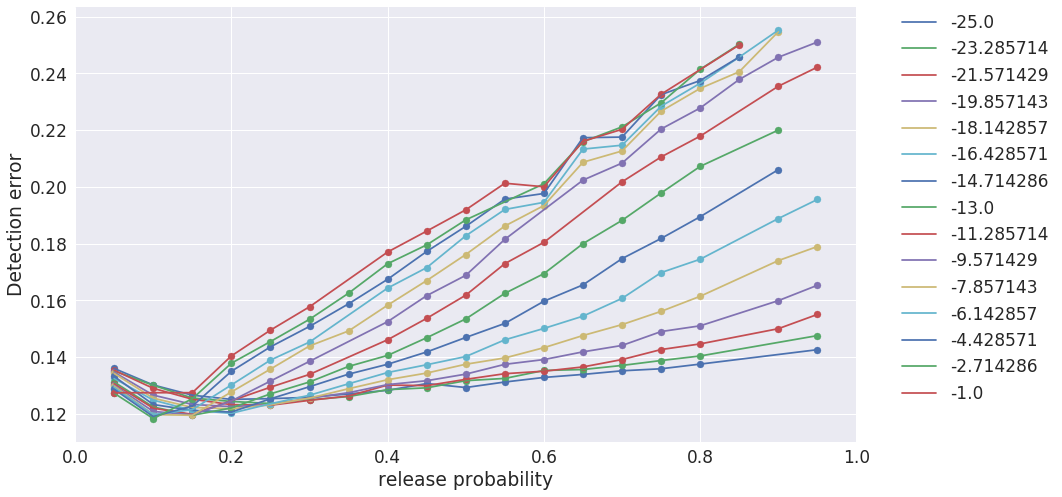

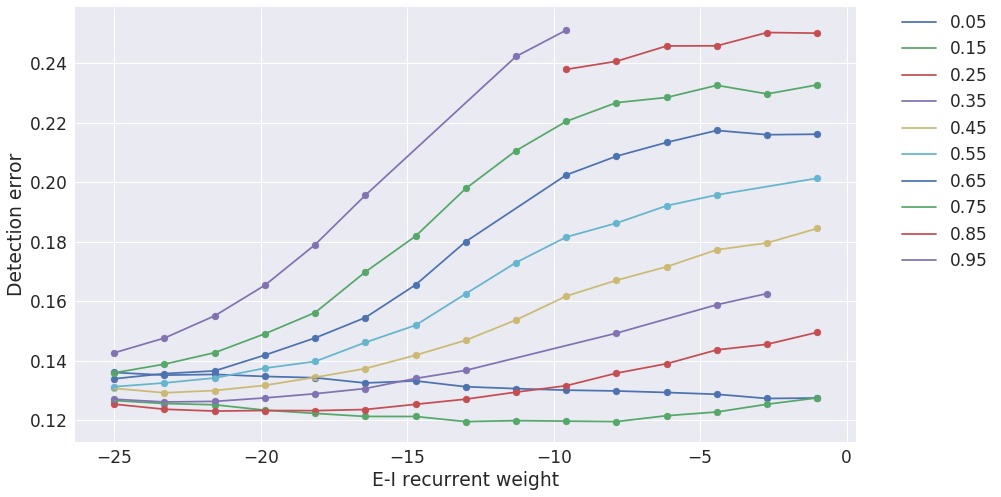

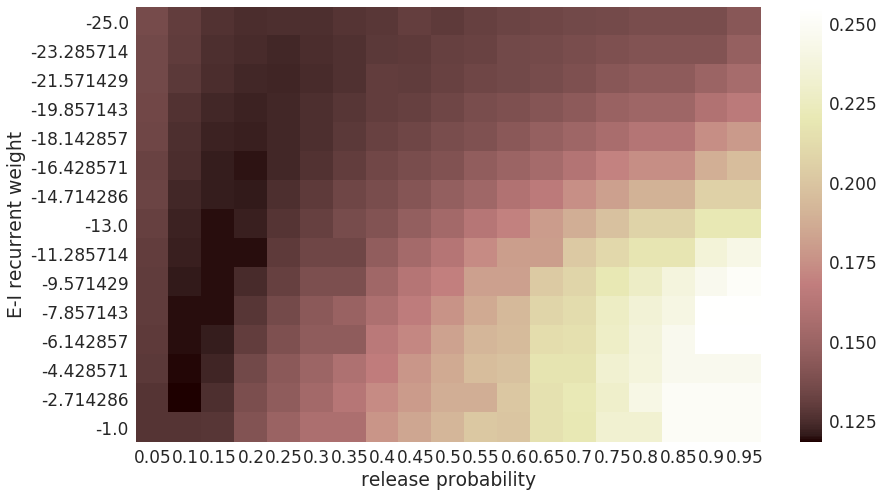

In [63]:
plot_error_vs_params(df, 
                     'release probability', 'E-I recurrent weight')

In [90]:
data = np.loadtxt('./data/results_weights.dat',
                  delimiter=',')
df = pd.DataFrame(data)
df.head()

0          1    2         3         4         5         6         7   \
0 -2.0  15.000000  0.3  0.405749  0.257309  0.217236  0.191424  0.165447   
1 -2.0  17.777778  0.3  0.400679  0.251558  0.214318  0.190845  0.165694   
2 -2.0  20.555556  0.3  0.396765  0.250468  0.215541  0.191649  0.165544   
3 -2.0  23.333333  0.3  0.395256  0.250310  0.215961  0.195160  0.170497   
4 -2.0  26.111111  0.3  0.391012  0.251453  0.218826  0.196900  0.173658   

         8         9         10        11        12  
0  0.156361  0.142337  0.129688  0.121442  0.115854  
1  0.157321  0.144020  0.131467  0.123886  0.118578  
2  0.160295  0.146633  0.135178  0.128198  0.123414  
3  0.165009  0.152265  0.140877  0.134617  0.129517  
4  0.168207  0.157012  0.145570  0.140434  0.135996

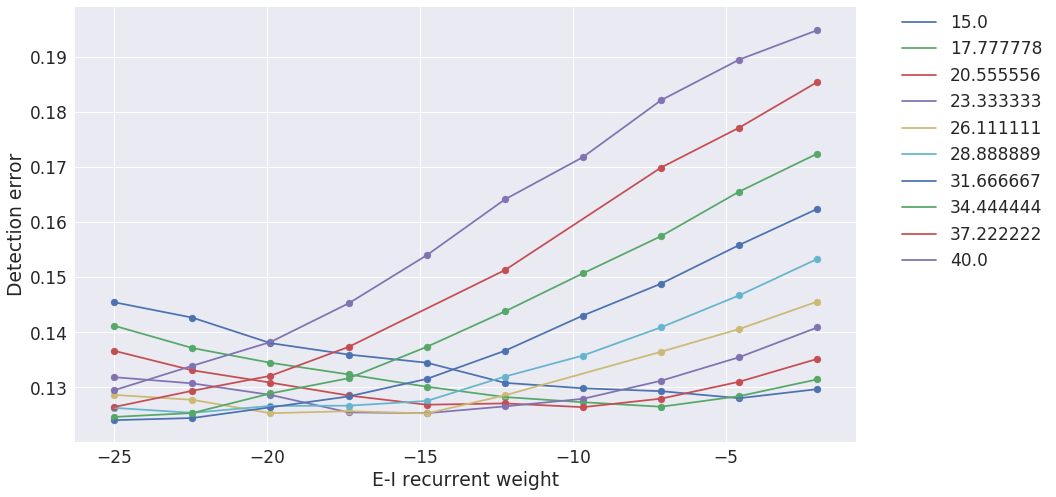

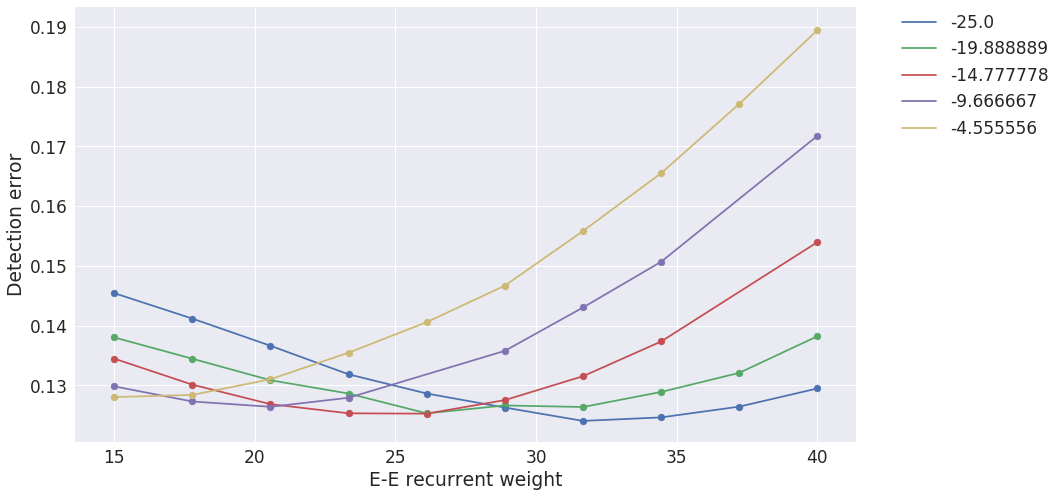

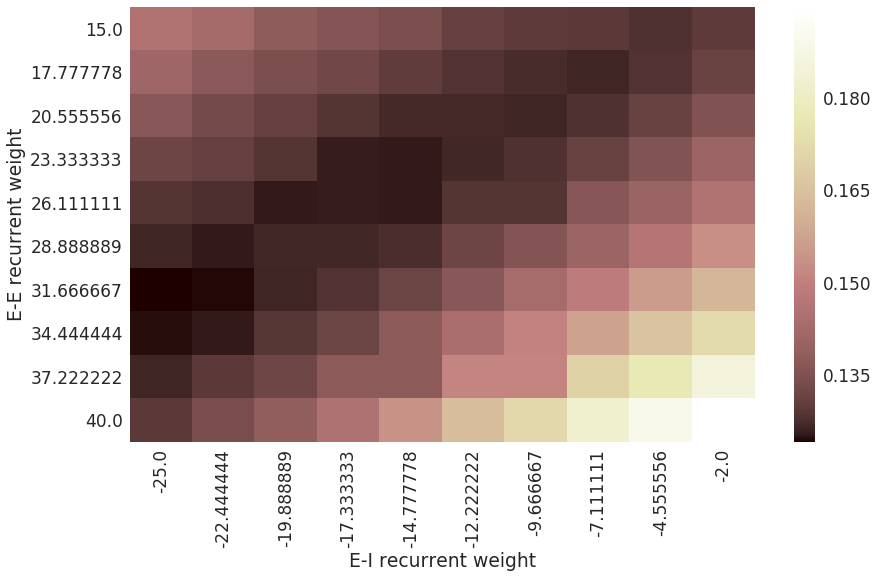

In [65]:
# U fixed at 0.3
plot_error_vs_params(df, 
                     'E-I recurrent weight', 'E-E recurrent weight')

An approximately linear dependence of E-E and E-I weights guarantees an optimal error

In [91]:
data = np.loadtxt('./data/results_stptime.dat',
                  delimiter=',')
df = pd.DataFrame(data)
df.head()

0         1     2         3         4         5         6         7   \
0  0.05  0.100000  0.05  0.411554  0.269191  0.227356  0.197521  0.169626   
1  0.05  0.235714  0.05  0.411910  0.270243  0.227992  0.196981  0.169759   
2  0.05  0.371429  0.05  0.414027  0.267569  0.228061  0.196797  0.169609   
3  0.05  0.507143  0.05  0.414620  0.269965  0.231234  0.198698  0.171778   
4  0.05  0.642857  0.05  0.415550  0.272585  0.229188  0.199320  0.170099   

         8         9         10        11        12  
0  0.157990  0.143715  0.130382  0.121139  0.114161  
1  0.157664  0.144748  0.130684  0.120932  0.114392  
2  0.158659  0.144658  0.129669  0.121927  0.115966  
3  0.160604  0.145301  0.130329  0.121970  0.114678  
4  0.160062  0.144772  0.131495  0.122736  0.114868

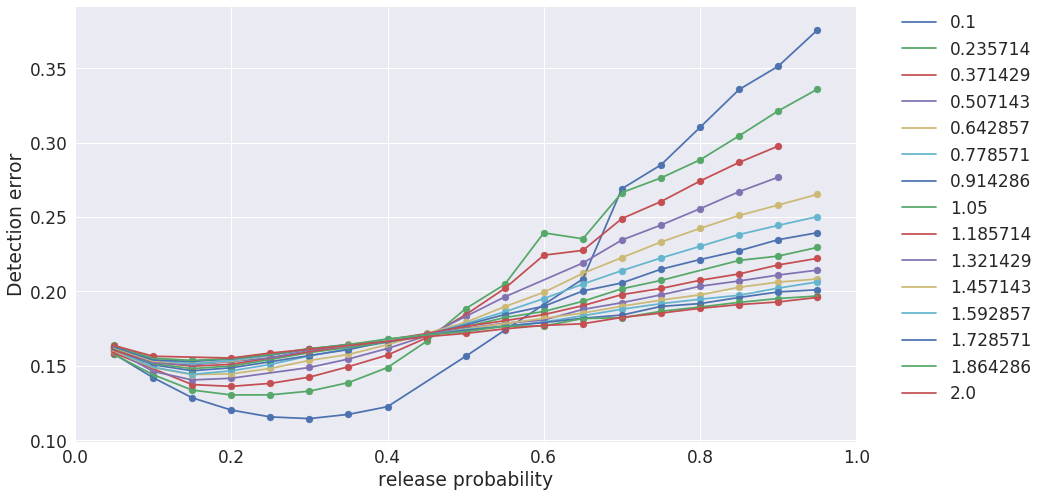

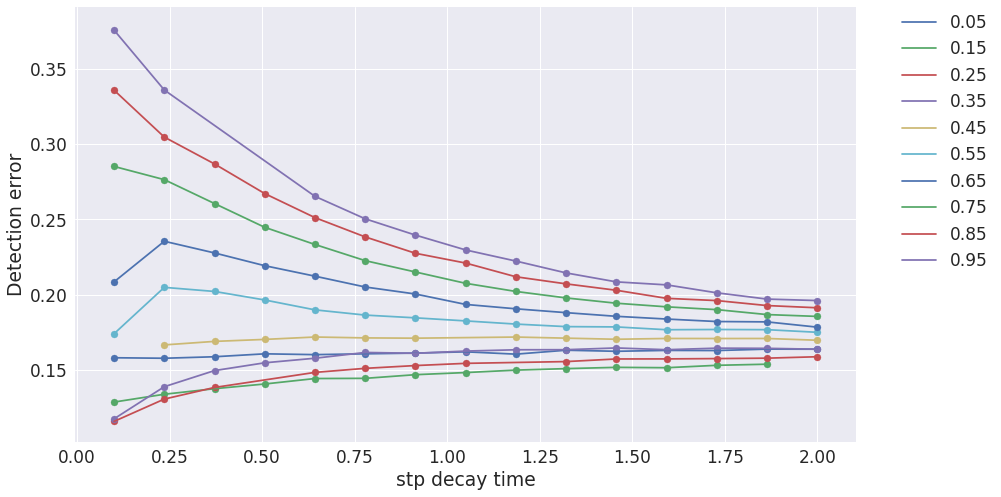

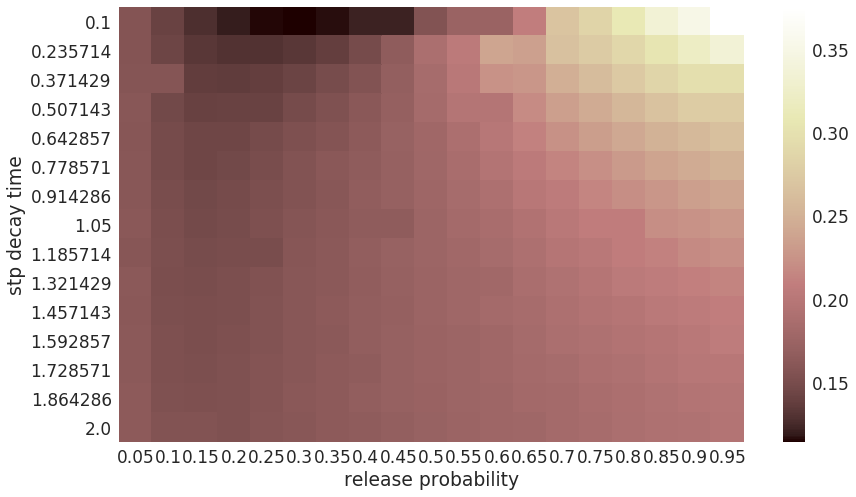

In [67]:
plot_error_vs_params(df, 
                     'release probability', 'stp decay time',
                     readout_index=8)

The error vs. $U$ curve gets more flat with increasing STD decay time, but error at high $U$ values decreases, e.g. average detection error over $U$ values decreases

In [68]:
np.sort(df[1].value_counts().index.values)

array([0.1     , 0.235714, 0.371429, 0.507143, 0.642857, 0.778571,
       0.914286, 1.05    , 1.185714, 1.321429, 1.457143, 1.592857,
       1.728571, 1.864286, 2.      ])

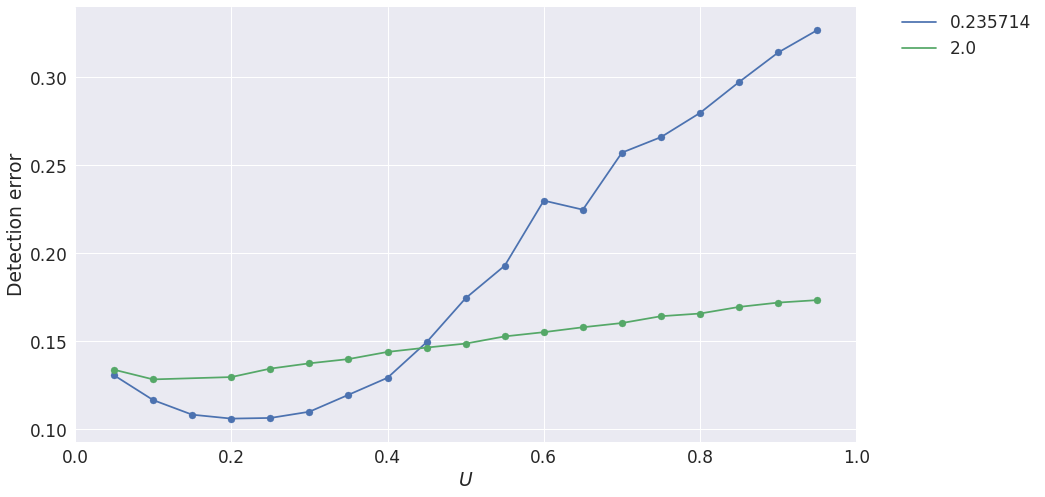

In [78]:
second_param_values = [0.235714, 2.]

for second_param in second_param_values:

    first_param = df[df[1] == second_param][0].values
    error = df[df[1] == second_param][readout_index].values
    p.plot(first_param, error)
    p.scatter(first_param, error)
        
    p.legend(second_param_values, 
             bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    p.xlabel('$U$')
    p.ylabel('Detection error')


We can do a bootstrap estimate of the error here as well, since we want to have short simulations, but a stable estimate of the average error


Also directly plot error bars since we have an error distribution over stimulus events
